In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pydantic import BaseModel, Field
from pymoo.indicators import spacing

In [28]:
filename = "results_temp.json"


class OneExperimentResults(BaseModel):
    problemName: str = Field(description="Name of the problem")
    method: str = Field(description="Name of the method")
    runID: int = Field(description="Run number")
    hv: list[float] = Field(description="Hypervolume (Normalized) of the found solutions at each iteration")
    IDG: list[float] = Field("IGD of the found solutions at each iteration")
    spacing: list[float | None] = Field("Spacing indicator value of the found solutions at each iteration")
    CumBadRefs: list[float] = Field(description="Cumulative fraction of bad reference points found at each iteration")
    success: list[bool] = Field(description="Whether the method evaluated a valid reference point at each iteration")
    runtime: float = Field(description="Runtime of the experiment")


class ExperimentResults(BaseModel):
    results: list[OneExperimentResults] = Field(description="Results of the experiment")


with open(filename, "r") as f:
    data = f.read()

results = ExperimentResults.model_validate_json(data)

In [31]:
# 3 Objective forest results

problem = "dtlz7"
f_results = [r for r in results.results if r.problemName == problem]
methods = list(set([r.method for r in f_results]))
runIDs = list(set([r.runID for r in f_results]))

f_pd = pd.DataFrame(
    columns=["method", "runID", "iteration", "HV", "IGD", "spacing" "Bad Reference Points Found", "success", "runtime"]
)

for r in f_results:
    # print lenghts
    to_add = pd.DataFrame(
        {
            "method": [r.method] * len(r.CumBadRefs),
            "runID": [r.runID] * len(r.CumBadRefs),
            "iteration": range(len(r.CumBadRefs)),
            "HV": r.hv + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "IGD": r.IDG + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "spacing": r.spacing + [np.nan] * (len(r.CumBadRefs) - len(r.hv)),
            "Bad Reference Points Found": r.CumBadRefs,
            "success": np.array(r.success).astype(int),
            "runtime": [r.runtime] * len(r.CumBadRefs),
        }
    )
    f_pd = pd.concat([f_pd, to_add])

Text(0.5, 1.0, 'Spacing indicator for dtlz7')

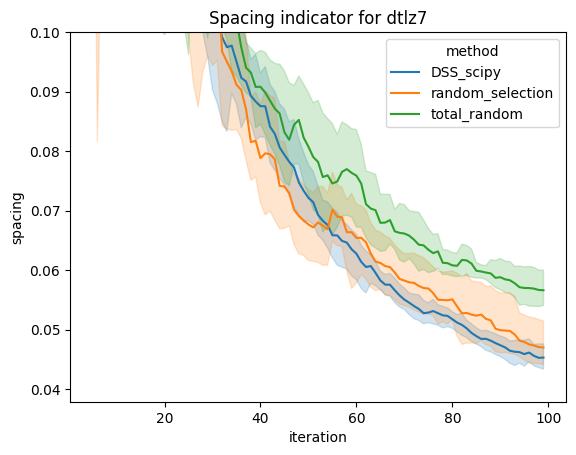

In [32]:
f, ax = plt.subplots()
ax.set()
f_pd_clean = f_pd[["spacing", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd_clean, y="spacing", x="iteration", hue="method")

# Set y-axis limits
ax.set_ylim(0.9 * f_pd_clean["spacing"].min(), 0.1)
ax.set_title(f"Spacing indicator for {problem}")

# For problems where all RPs are eliminated, try recalculating the 
# bad RPs with lower threshold values.

(0.016155393369363526, 0.1)

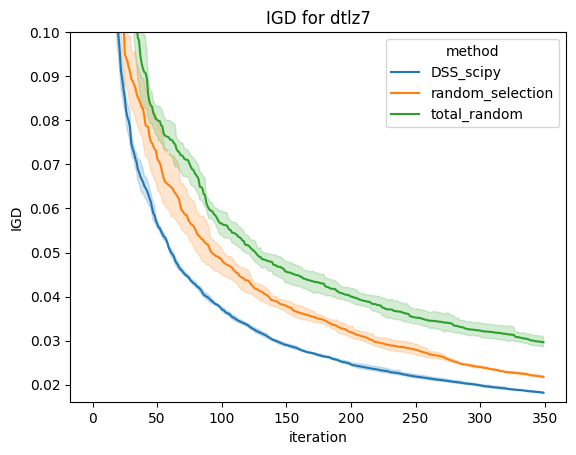

In [44]:
f, ax = plt.subplots()
#ax.set(yscale="log", xscale="log")

f_pd = f_pd[["IGD", "iteration", "method"]].dropna()
sns.lineplot(data=f_pd, x="iteration", y="IGD", hue="method")
ax.set_title(f"IGD for {problem}")
ax.set_ylim(0.9 * f_pd["IGD"].min(), 0.1)

# f.savefig(f"igd_{problem}.png")

<Axes: xlabel='iteration', ylabel='1-HV'>

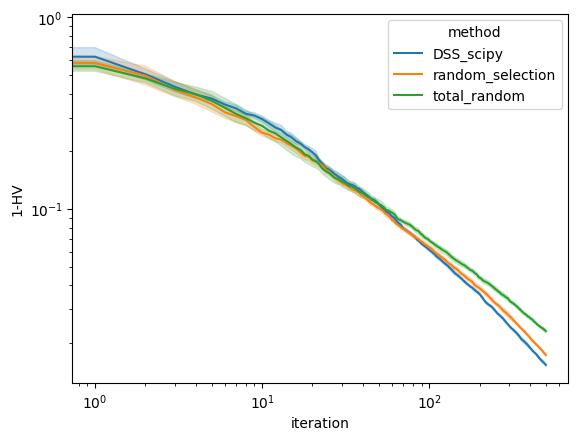

In [30]:
f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
f_pd["1-HV"] = 1 - f_pd["HV"]
sns.lineplot(data=f_pd, x="iteration", y="1-HV", hue="method")

# f.savefig(f"hv_{problem}.png")

In [5]:
rolling = pd.DataFrame(columns=["method", "runID", "iteration", "success"])

In [6]:
ids = f_pd["runID"].unique()
methods = f_pd["method"].unique()

for method in methods:
    for runID in ids:
        r = f_pd[(f_pd["method"] == method) & (f_pd["runID"] == runID)]
        rolling = pd.concat(
            [
                rolling,
                pd.DataFrame(
                    {
                        "method": [method] * len(r),
                        "runID": [runID] * len(r),
                        "iteration": r["iteration"],
                        "success": r["success"].cumsum(),
                    }
                ),
            ]
        )
rolling = rolling.dropna()

<Axes: xlabel='iteration', ylabel='success'>

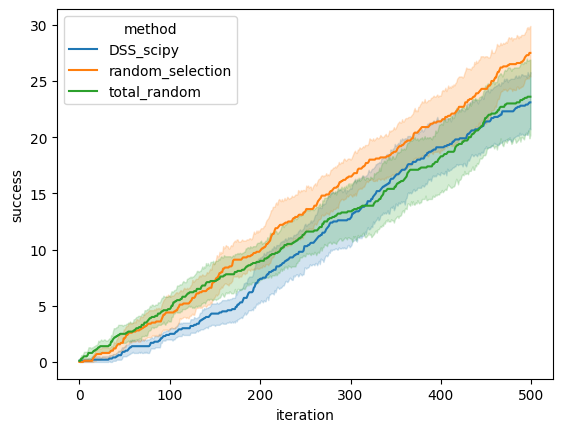

In [7]:
f, ax = plt.subplots()
sns.lineplot(data=rolling, x="iteration", y="Cumulative success", hue="method")
# f.savefig(f"success_{problem}.png")

<Axes: xlabel='iteration', ylabel='Bad Reference Points Found'>

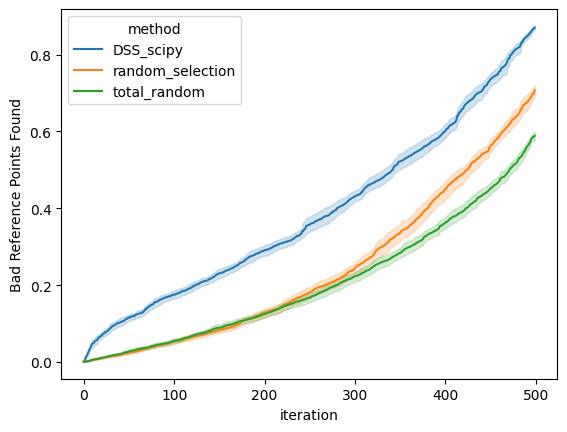

In [34]:
f, ax = plt.subplots()
sns.lineplot(data=f_pd, x="iteration", y="Bad Reference Points Found", hue="method")
# f.savefig(f"bad_ref_found_{problem}.png")